<a href="https://colab.research.google.com/github/DimpleDR/Computational-Data-Science/blob/Projects/M6_SNB_MiniProject_2_Face_Mask_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Certification Program in Computational Data Science

##  A program by IISc and TalentSprint

### Mini Project Notebook: Face Mask Detection using Convolutional Neural Networks

**DISCLAIMER:** THIS NOTEBOOK IS PROVIDED ONLY AS A REFERENCE SOLUTION NOTEBOOK FOR THE MINI-PROJECT. THERE MAY BE OTHER POSSIBLE APPROACHES/METHODS TO ACHIEVE THE SAME RESULTS.

## Learning Objectives

At the end of the experiment, you will be able to :

* load and extract features of images using ImageDataGenerator

* build the convolutional neural networks

* use the pre-trained models using keras applications

## Introduction

This project uses a Deep Neural Network, more specifically a Convolutional Neural Network, to differentiate between images of people, with masks, without masks and incorrectly placed masks. Manually built and pretrained networks will be used to perform this classification task.

**Face-Mask-Detection-Using-CNN**

* Outbreak of the Coronavirus pandemic has created various changes in the lifestyle of everyone around the world.
* Among these changes, wearing a mask has been very vital to every individual.
* Detection of people who are not wearing masks is a challenge due to the large populations.
* This face mask detection project can be used in schools, hospitals, banks, airports etc as a digitalized scanning tool.
  - The technique of detecting people’s faces and segregating them into three classes namely the people with masks and people without masks and partial masks is done with the help of image processing and deep learning.
* With the help of this project, a person who is monitoring the face mask status for a particular firm can be seated in a remote area and still monitor efficiently and give instructions accordingly.

![img](https://cdn.iisc.talentsprint.com/CDS/MiniProjects/dataset-images-with-mask.jpg)

## Dataset

The data for this mini-project is collected from various sources including the masked images from internet and general frontal face images considered as without mask. This dataset consists of 5029 train images and 1259 test images with 3 classes `with_mask`, `without_mask` and `partial_mask`

Many people are not correctly wearing their masks due to bad practices, bad behaviors or vulnerability of individuals (e.g., children, old people). For these reasons, several mask wearing campaigns intend to sensitize people about this problem and good practices. In this sense, this work proposes three types of masked face detection dataset

- Without Mask/ With Mask/ Partial Mask

Note that this dataset contains some annotated (artificially generated) masks to augment the 'masked' data category.

## Problem Statement

To build and implement a Convolutional Neural Network model to classify between masked/unmasked/partially masked faces.

In [1]:
#@title Download the data
!wget -qq https://cdn.iisc.talentsprint.com/CDS/MiniProjects/MP2_FaceMask_Dataset.zip
!unzip -qq MP2_FaceMask_Dataset.zip
print("Data Downloaded Successfuly!!")

Data Downloaded Successfuly!!


### Import Required packages

In [2]:
from tensorflow.keras.optimizers import RMSprop
#from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense,Dropout
from keras.models import Model, load_model
from keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import numpy as np
import pandas as pd
import PIL
from matplotlib import pyplot as plt
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow import keras
import glob, os

### Analyzing the shape and distribution of datasets

In [3]:
partial = glob.glob("/content/MP2_FaceMask_Dataset/train/partial_mask/*")
on = glob.glob("/content/MP2_FaceMask_Dataset/train/with_mask/*")
off = glob.glob("/content/MP2_FaceMask_Dataset/train/without_mask/*")
len(partial), len(on), len(off)

(1294, 1624, 2138)

In [4]:
total = partial + on + off
len(total)

5056

In [5]:
height, width  = [],[]
for i in total:
  im = PIL.Image.open(i)
  height.append(np.array(im).shape[0])
  width.append(np.array(im).shape[1])

In [6]:
print(max(height),min(height), sum(height)/len(height))
print(max(width),min(width),sum(width)/len(width))

4608 141 449.3785601265823
3456 110 434.44026898734177


### Load the images using ImageDataGenerator

There are two main steps involved in creating the generator.
1. Instantiate ImageDataGenerator with required arguments to create an object
2. Use the `flow_from_directory` command depending on how your data is stored on disk. This is the command that will allow you to generate and get access to batches of data on the fly.

Hint: [link](https://keras.io/api/preprocessing/image/)

In [7]:
TRAINING_DIR = "/content/MP2_FaceMask_Dataset/train/"
VALIDATION_DIR = "/content/MP2_FaceMask_Dataset/test/"

In [8]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   rotation_range=40,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=10,target_size=(224, 224))

validation_datagen = ImageDataGenerator(rescale=1.0/255,
                                        zoom_range=0.2,
                                        horizontal_flip=True,
                                        fill_mode='nearest')
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                         batch_size=50,
                                                         target_size=(224, 224))

Found 5029 images belonging to 3 classes.
Found 1259 images belonging to 3 classes.


In [9]:
train_generator.class_indices

{'partial_mask': 0, 'with_mask': 1, 'without_mask': 2}

In [10]:
next(train_generator)[0].shape

(10, 224, 224, 3)

In [11]:
input_shap = next(train_generator)[0].shape[1:]
input_shap

(224, 224, 3)

### Visualize the sample images of each class using data generator

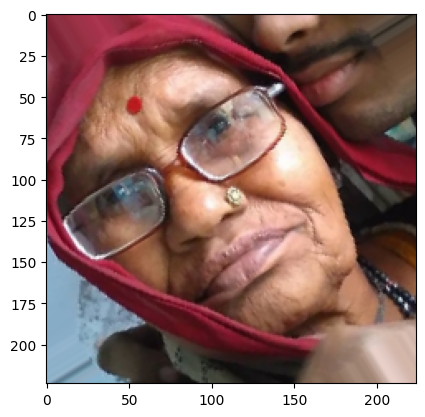

In [12]:
plt.imshow(next(train_generator)[0][0]);

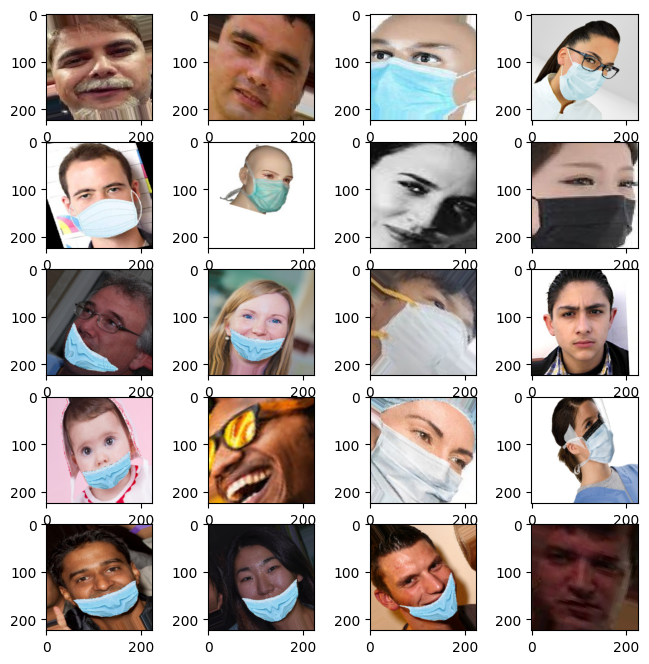

In [13]:
fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(next(train_generator)[0][0])
plt.show()

## Build the CNN model using Keras



**Convolutional Neural Network:** A neural network in which at least one layer is a convolutional layer. A typical convolutional neural network consists of some combination of the following layers:

* convolutional layers
* pooling layers
* dense layers


**Conv2D**

Passing an image with input shape of 3-D and to calculate the output:

 $O = \frac{n - f + 2p}{s} + 1$

 where

 $n$ = image dimension

 $f$ = filter size

 $p$ = padding

 $s$ = stride

**MaxPool**

The resulting output, when using the "valid" padding option, has a spatial shape (number of rows or columns) of:

O = `math.floor`$(\frac{input shape - pool size)}{ strides}) + 1$ (when input shape >= pool size)

The resulting output shape when using the "same" padding option is:

O = `math.floor`$(\frac{input shape - 1}{strides}) + 1$

by default, stride = None, so stride is same as pool size

Task-flow
* Initialize the network of convolution, maxpooling and dense layers
* Define the optimizer and loss functions
* Fit the model and evaluate the model

**model 1 with 2 convolutional (feature representation) and 2 maxpool layers (down sampling) and 2 dense layers for classification.**

In [14]:
model1 = Sequential([
    Conv2D(100, (3,3), activation='relu', input_shape=(input_shap)),            #convolutional layer 1: No. of filters=100, filter size=3x3, activation = relu, input_shap = 224x224x3,
    MaxPooling2D(2,2),                                                          #Maxpooling2D filter size=2x2

    Conv2D(100, (3,3), activation='relu'),                                      #convolutional layer 2: No. of filters=100, filter size=3x3, activation = relu,
    MaxPooling2D(2,2),                                                          #Maxpooling2D filter size=2x2

    Flatten(),
    Dropout(0.5),
    Dense(50, activation='relu'),
    Dense(train_generator.num_classes, activation='softplus')
])
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
model1.summary()
#Note: Applying a convolution to an image will make it smaller (if no padding).
#Convolving a 3x3 filter over images means we’ll lose a single pixel on all sides (2 in total).
#In the given case, sliding a 3x3 filter over a 224x224 image results in a 222x222 image

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 100)       │           2,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 100)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 100)       │          90,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 100)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 291600)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 291600)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 50)                  │      14,580,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             153 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,673,103 (55.97 MB)

 Trainable params: 14,673,103 (55.97 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# It will take around 11 minutes to run on T4 GPU on Google Colab
history1 = model1.fit(train_generator,epochs=5,validation_data=validation_generator)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


503/503 ━━━━━━━━━━━━━━━━━━━━ 111s 206ms/step - acc: 0.7048 - loss: 0.9571 - val_acc: 0.9126 - val_loss: 0.3143
Epoch 2/5
503/503 ━━━━━━━━━━━━━━━━━━━━ 126s 184ms/step - acc: 0.9024 - loss: 0.2818 - val_acc: 0.8888 - val_loss: 0.3757
Epoch 3/5
503/503 ━━━━━━━━━━━━━━━━━━━━ 146s 190ms/step - acc: 0.8371 - loss: 0.4873 - val_acc: 0.7021 - val_loss: 0.4716
Epoch 4/5
503/503 ━━━━━━━━━━━━━━━━━━━━ 139s 186ms/step - acc: 0.7308 - loss: 0.5279 - val_acc: 0.4241 - val_loss: 0.6260
Epoch 5/5
503/503 ━━━━━━━━━━━━━━━━━━━━ 93s 183ms/step - acc: 0.4222 - loss: 0.6264 - val_acc: 0.4257 - val_loss: 0.6253


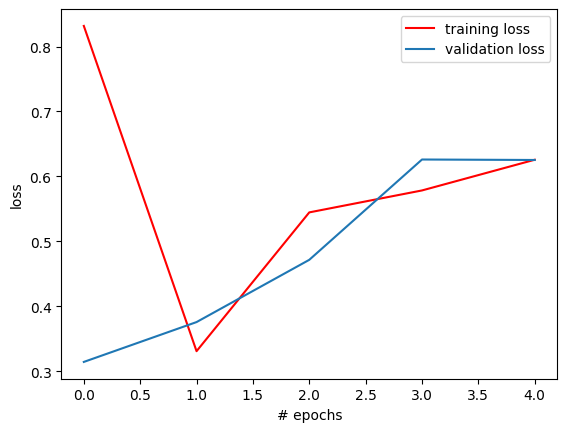

In [17]:
plt.plot(history1.history['loss'],'r',label='training loss')
plt.plot(history1.history['val_loss'],label='validation loss')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

**model 2 with few more conv layers**

In [18]:
model2 = Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape=(input_shap)),
    MaxPooling2D(2,2),

    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(64, (2,2),activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (2,2),activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dropout(0.5),
    Dense(1920, activation='relu'),
    Dense(480, activation='relu'),
    Dense(32, activation='relu'),
    Dense(train_generator.num_classes, activation='softmax')
])
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [19]:
# It will take around 10 minutes to run on T4 GPU on Google Colab
history2 = model2.fit(train_generator,epochs=5,validation_data=validation_generator)

Epoch 1/5
503/503 ━━━━━━━━━━━━━━━━━━━━ 107s 195ms/step - acc: 0.7673 - loss: 0.3451 - val_acc: 0.9404 - val_loss: 0.1344
Epoch 2/5
503/503 ━━━━━━━━━━━━━━━━━━━━ 125s 174ms/step - acc: 0.9358 - loss: 0.1386 - val_acc: 0.9380 - val_loss: 0.1062
Epoch 3/5
503/503 ━━━━━━━━━━━━━━━━━━━━ 143s 176ms/step - acc: 0.9519 - loss: 0.0949 - val_acc: 0.9325 - val_loss: 0.1389
Epoch 4/5
503/503 ━━━━━━━━━━━━━━━━━━━━ 141s 173ms/step - acc: 0.9519 - loss: 0.0991 - val_acc: 0.9571 - val_loss: 0.0872
Epoch 5/5
503/503 ━━━━━━━━━━━━━━━━━━━━ 89s 176ms/step - acc: 0.9599 - loss: 0.0850 - val_acc: 0.9619 - val_loss: 0.0999


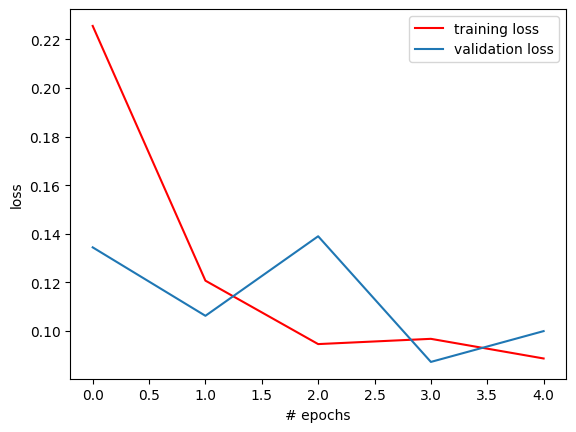

In [20]:
plt.plot(history2.history['loss'],'r',label='training loss')
plt.plot(history2.history['val_loss'],label='validation loss')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

## Transfer learning

Transfer learning consists of taking features learned on one problem, and leveraging them on a new, similar problem.

A pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task.

The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. You can then take advantage of these learned feature maps without having to start from scratch by training a large model on a large dataset.

For eg. Using VGG16, we remove the last layer which takes a probability for each of the 1000 classes in the ImageNet and replaces it with a layer that takes 3 probabilities in our case.

### Use the pre-trained models ([VGG16](https://cdn.exec.talentsprint.com/static/cds/content/M6_SNB_MiniProject_2_VGG16.pdf) or [ResNet50](https://cdn.exec.talentsprint.com/static/cds/content/M6_SNB_MiniProject_2_ResNet50.pdf))

* Load the pre-trained model
* Fit and evaluate the data

Hint: [How to use pre-trained model](https://towardsdatascience.com/step-by-step-guide-to-using-pretrained-models-in-keras-c9097b647b29)

#### Expected accuracy: Morethan 90%

Task-flow
* Initialize the network with the weights of Imagenet
* Fine tune the network by modifying fully connected layers.
* Re-train the model with our problem data

#### VGG16

In [21]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense
import tensorflow as tf

# Create the input layer explicitly
input_layer = Input(shape=input_shap)

# Load the VGG16 model without the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=input_layer)

# Flatten the output of the base model
x = Flatten()(base_model.output)

# Add a Dense layer
x = Dense(128, activation="relu", kernel_initializer="he_normal",
          kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)

# Add the output layer with the number of classes
output_layer = Dense(train_generator.num_classes, activation='softmax')(x)

# Define the final model
model_vgg = Model(inputs=input_layer, outputs=output_layer)

# Print the model summary
model_vgg.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 17,926,467 (68.38 MB)

 Trainable params: 17,926,467 (68.38 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# model_vgg = Sequential()
# model_vgg.add(VGG16(weights='imagenet',include_top=False,input_shape=(input_shap)))
# model_vgg.add(Flatten())
# model_vgg.add(Dense(128,activation="relu",kernel_initializer="he_normal",
#                            kernel_regularizer=keras.regularizers.l2(0.01)))
# model_vgg.add(Dense(train_generator.num_classes,activation='softmax'))
# model_vgg.summary()

In [23]:
optimizer_adam = keras.optimizers.Adam(learning_rate=0.00001)
model_vgg.compile(optimizer=optimizer_adam, loss='categorical_crossentropy', metrics=['acc'])

In [24]:
history3 = model_vgg.fit(train_generator,epochs=5,
                              validation_data=validation_generator, class_weight={0:1.0,1:0.8,2:1.2})

Epoch 1/5
503/503 ━━━━━━━━━━━━━━━━━━━━ 192s 332ms/step - acc: 0.8785 - loss: 2.6627 - val_acc: 0.9881 - val_loss: 2.0152
Epoch 2/5
503/503 ━━━━━━━━━━━━━━━━━━━━ 124s 245ms/step - acc: 0.9881 - loss: 1.9111 - val_acc: 0.9809 - val_loss: 1.6768
Epoch 3/5
503/503 ━━━━━━━━━━━━━━━━━━━━ 123s 244ms/step - acc: 0.9897 - loss: 1.5572 - val_acc: 0.9936 - val_loss: 1.3621
Epoch 4/5
503/503 ━━━━━━━━━━━━━━━━━━━━ 126s 248ms/step - acc: 0.9943 - loss: 1.2875 - val_acc: 0.9905 - val_loss: 1.1493
Epoch 5/5
503/503 ━━━━━━━━━━━━━━━━━━━━ 124s 245ms/step - acc: 0.9927 - loss: 1.0921 - val_acc: 0.9913 - val_loss: 0.9745


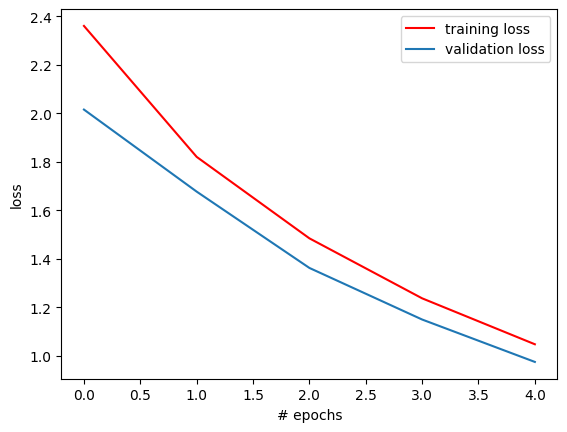

In [25]:
plt.plot(history3.history['loss'],'r',label='training loss')
plt.plot(history3.history['val_loss'],label='validation loss')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [26]:
# Save the model in HDF5 format
model_vgg.save('model_vgg.h5')

In [27]:
# Save the model in keras format
model_vgg.save('model_vgg.keras')

#### ResNet50

In [28]:
model_resnet = Sequential()
model_resnet.add(ResNet50(weights='imagenet',include_top=False,input_shape=input_shap))
model_resnet.add(Flatten())
model_resnet.add(Dense(128))
model_resnet.add(Dense(train_generator.num_classes,activation='softmax'))
model_resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
## model_resnet.build((next(train_generator)[0].shape))
model_resnet.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │      12,845,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 36,433,283 (138.98 MB)

 Trainable params: 36,380,163 (138.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [29]:
# It will take around 13 minutes to run on T4 GPU on Google Colab
history4 = model_resnet.fit(train_generator,epochs=5,
                    validation_data=validation_generator)

Epoch 1/5
503/503 ━━━━━━━━━━━━━━━━━━━━ 198s 280ms/step - acc: 0.7595 - loss: 35.4397 - val_acc: 0.4345 - val_loss: 2.1475
Epoch 2/5
503/503 ━━━━━━━━━━━━━━━━━━━━ 141s 213ms/step - acc: 0.9127 - loss: 1.3307 - val_acc: 0.8880 - val_loss: 0.3550
Epoch 3/5
503/503 ━━━━━━━━━━━━━━━━━━━━ 141s 211ms/step - acc: 0.9343 - loss: 1.0848 - val_acc: 0.8586 - val_loss: 7.9241
Epoch 4/5
503/503 ━━━━━━━━━━━━━━━━━━━━ 145s 218ms/step - acc: 0.8982 - loss: 1.1866 - val_acc: 0.9682 - val_loss: 0.2055
Epoch 5/5
503/503 ━━━━━━━━━━━━━━━━━━━━ 139s 212ms/step - acc: 0.9541 - loss: 0.2158 - val_acc: 0.9666 - val_loss: 0.1537


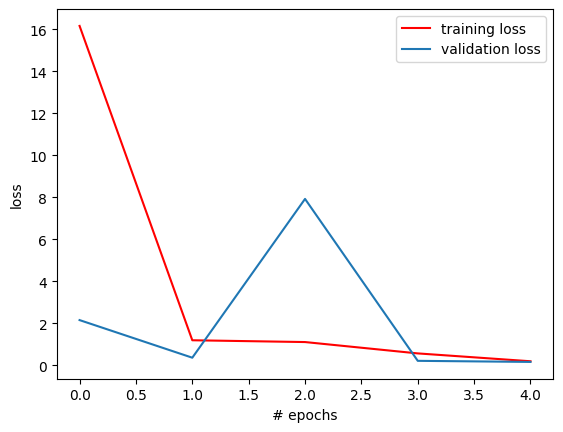

In [30]:
plt.plot(history4.history['loss'],'r',label='training loss')
plt.plot(history4.history['val_loss'],label='validation loss')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

### Capture the live image using the below code cell and predict

<IPython.core.display.Javascript object>

Saved to photo.jpg


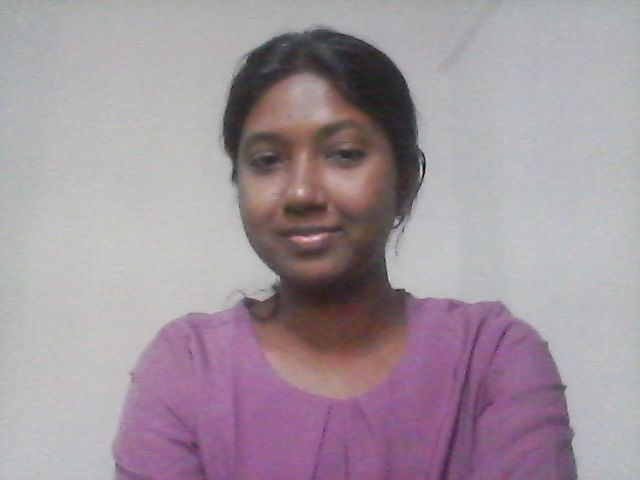

In [32]:
#@title Capture the photo
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  display(Image(filename))
except Exception as err:
  print(str(err))

After executing above cell and capturing the photo, load the captured photo and predict with model.

**Note:**
* Convert the image to numpy array and resize to the shape which model accept.
* Extend the dimension (to 4-D shape) of an image, as the model is trained on a batch of inputs.

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
fc =  [[0. 0. 1.]]
labels to decode  {'partial_mask': 0, 'with_mask': 1, 'without_mask': 2}
argmax of fc  2


'without_mask'

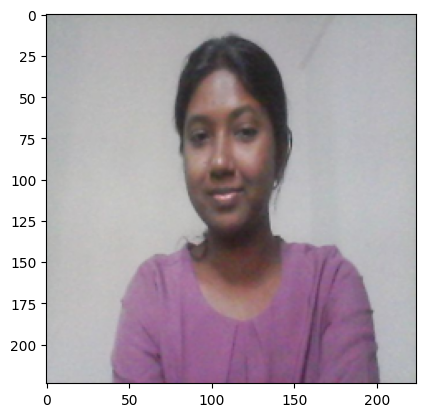

In [33]:
MODEL = model_vgg
features = PIL.Image.open("photo.jpg")
features = features.resize((224, 224))
plt.imshow(features);
features = np.array(features).reshape(1, 224,224,3)
predicted = MODEL.predict(features)
print("fc = ",predicted)
print("labels to decode ",train_generator.class_indices)
print("argmax of fc ",np.argmax(predicted))
list(train_generator.class_indices.keys())[np.argmax(predicted)]

### Report Analysis

- Compare the accuracies for the Pre-trained vs CNN models
- Which model detects the mask/no mask/ partial mask more accurately with the live pictures?
- What process was followed to tune the hyperparameters?
- Discuss the confusion matrix in terms of the misclassifications

### Kaggle predictions

In [34]:
# Download the saved VGG model
!wget -qq https://cdn.exec.talentsprint.com/static/cds/content/model_vgg.h5

In [35]:
# Download the saved Keras model
!wget -qq https://cdn.exec.talentsprint.com/static/cds/content/model_vgg.keras

### Instructions for preparing Kaggle competition predictions

Important: Refer the [Kaggle Team Creation Instructions Doc](https://drive.google.com/file/d/1V0GlyApGPvksSEPhlfkJIQndt4zIBOdY/view?usp=drive_link)

* Load the image paths from Kaggle testset using `glob`
* Read the Images using `PIL.Image.open` and resize to required shape.
* Get the predictions using trained model and prepare a csv file
  - FC layer of DeepNet model gives output for each class, consider the maximum value among all classes as prediction using `np.argmax`.
* Predictions (csv) file should contain 2 columns as Sample_Submission.csv
  - First column is the img_path which is considered as index
  - Second column is prediction in decoded form (for eg. with_mask, partial_mask, without_mask).
  - Note that at the time of submission to Kaggle, predictions need to be sorted in ascending order i.e, same as sample submission file.

<font color='magenta'>If you are unable to download the data and sample submission from the Kaggle Competition site then please use the download cell below.</font>


In [36]:
#@title Download test data and SampleSubmission file for Kaggle submission
!wget -qq https://cdn.iisc.talentsprint.com/CDS/MiniProjects/FaceMask_Kaggle_test.zip
!unzip -qq FaceMask_Kaggle_test.zip
!wget -qq https://cdn.iisc.talentsprint.com/CDS/Datasets/Sample_Submission.csv
print("Data Downloaded Successfuly!!")

Data Downloaded Successfuly!!


#### Create a dataframe with kaggle data

In [37]:
df = pd.DataFrame()
df['img_path'] = glob.glob("FaceMask_Kaggle_test/*")
df['order'] = [int(i.split("/")[1][:-4]) for i in df['img_path']]
df.sort_values('order',inplace=True)
df.reset_index(inplace=True,drop=True)
df

,img_path,order
0,FaceMask_Kaggle_test/1.jpg,1
1,FaceMask_Kaggle_test/2.jpg,2
2,FaceMask_Kaggle_test/3.jpg,3
3,FaceMask_Kaggle_test/4.jpg,4
4,FaceMask_Kaggle_test/5.jpg,5
...,...,...
655,FaceMask_Kaggle_test/656.jpg,656
656,FaceMask_Kaggle_test/657.jpg,657
657,FaceMask_Kaggle_test/658.jpg,658
658,FaceMask_Kaggle_test/659.jpg,659


In [38]:
df.iloc[120:135]

,img_path,order
120,FaceMask_Kaggle_test/121.jpg,121
121,FaceMask_Kaggle_test/122.jpg,122
122,FaceMask_Kaggle_test/123.jpg,123
123,FaceMask_Kaggle_test/124.jpg,124
124,FaceMask_Kaggle_test/125.jpg,125
125,FaceMask_Kaggle_test/126.jpg,126
126,FaceMask_Kaggle_test/127.jpg,127
127,FaceMask_Kaggle_test/128.jpg,128
128,FaceMask_Kaggle_test/129.jpg,129
129,FaceMask_Kaggle_test/130jpeg,130


#### Extract features of kaggle data

In [39]:
kaggle_features = []
for i in df.img_path:
  im = np.array(PIL.Image.open(i).resize((224,224)))
  if im.shape != (224,224,3):
    print(i, im.shape)
  kaggle_features.append(im)

kaggle_features = np.array(kaggle_features)

#### Load the saved model and predict the kaggle features

In [40]:
import tensorflow as tf
# Ensure consistent usage of TensorFlow's Keras
model = tf.keras.models.load_model('/content/model_vgg.h5', compile=False)

In [41]:
# Loading the saved model
# model = keras.models.load_model('/content/model_vgg.h5')

In [42]:
pred = model.predict(kaggle_features)

21/21 ━━━━━━━━━━━━━━━━━━━━ 30s 766ms/step


In [43]:
act_pred = np.argmax(pred,axis=1)
set(act_pred)

{0, 1, 2}

#### Prepare the kaggle predictions CSV file after decoding the integer predictions

In [44]:
kaggle = pd.DataFrame()
kaggle['label'] = act_pred
kaggle['img_path'] = df['img_path']
kaggle['label'].replace(0,'partial_mask',inplace=True)
kaggle['label'].replace(1,'with_mask',inplace=True)
kaggle['label'].replace(2,'without_mask',inplace=True)

<ipython-input-44-06419f9ae55b>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  kaggle['label'].replace(0,'partial_mask',inplace=True)


In [45]:
kaggle.to_csv("kaggle_submission_w2.csv",index=False)